# SOUND SIGNAL CLASSIFICATION USING DEEP LEARNING PROJECT

This project consists of 3 main steps:

- Step 1. We will prepare our dataset for analysis and extract sound signal features from  audio files using Mel-Frequency Cepstral Coefficients(MFCC).
- Step 2. Then we will build a Convolutional Neural Networks (CNN) model and train our model with our dataset. 
- Step 3: Finally We Predict an Audio File's Class Using Our CNN Deep Learning Model



We will use UrbanSound8K Dataset, download Link is here: https://urbansounddataset.weebly.com/download-urbansound8k.html

Dataset folder and this source code should be on same directory..

Don't forget to install librosa library using anaconda promt with the following command line:

conda install -c conda-forge librosa
        

### Step 1: We will prepare our dataset for analysis and extract sound signal features from  audio files using Mel-Frequency Cepstral Coefficients(MFCC).

Every signal has its own characteristics. In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound. Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.

You can get detailed info about MFC on : https://www.youtube.com/watch?v=4_SH2nfbQZ8&t=0s

So by using librosa library we will get characteristics of every audio signal in our dataset and hold them in a list.

In [1]:
from google.colab import drive
drive.mount('gdrive')

%cd /content/gdrive/MyDrive/Colab\ Notebooks/Audio\ Signal\ Classification\ uising\ deep\ learning

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Audio Signal Classification uising deep learning


In [2]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import numpy as np
import os, fnmatch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [4]:
!ls

audio_info.csv	 model
audiosignal.png  sound_signal_classification_with_deep_learning.ipynb
checkpoint	 UrbanSound8K


In [5]:
# First I want to show to how librosa handles sound signals.
# Let's read an example audio signal using librosa
audio_file_path='UrbanSound8K/179096-3-0-1.wav'

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [6]:
# An important thing you should know about librosa is librosa converts any stereo(2 channel) signal into mono(single channel). 
# So librosa converted signal data is one dimensional since it converts all signals(2 channels) into single channel(mono) 
# and get signal characteristics of your sound file over this mono signal form..

print(librosa_audio_data)

[3.8973769e-04 3.2189346e-04 1.9633044e-06 ... 1.2723202e-03 1.1912817e-03
 1.4401989e-03]


In [7]:
librosa_audio_data.shape

(88200,)

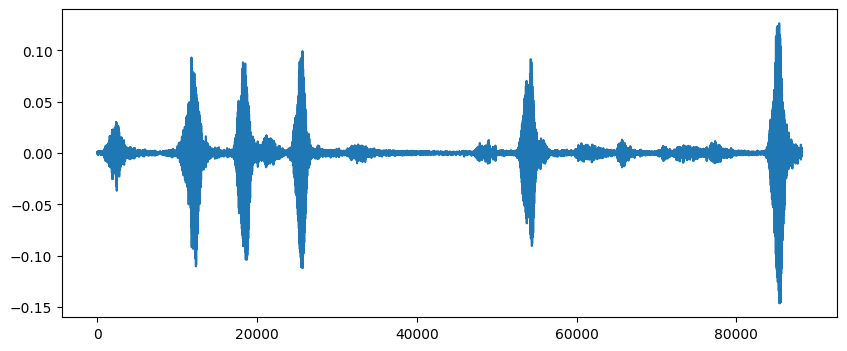

In [8]:
# Plot the librosa audio data
# Audio with 1 channel 
plt.figure(figsize=(10, 4))
plt.plot(librosa_audio_data)
plt.show()

In [9]:
librosa_sample_rate

22050

#### Here We will Extract Features of all Sound  Signals in the UrbanSound8K Dataset

Now we will calculate the Mel-Frequency Cepstral Coefficients(MFCC) of the audio samples. The MFCC calculate the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. Using this audio signal characteristics we can identify audio features for classification.


In [10]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=45)   #n_mfcc: number of MFCCs to return 
print(mfccs.shape)

(45, 173)


In [11]:
mfccs

array([[-5.6404572e+02, -5.1310059e+02, -4.7235077e+02, ...,
        -4.3382501e+02, -4.5566791e+02, -4.8125854e+02],
       [ 8.4583466e+01,  1.0821834e+02,  1.2617972e+02, ...,
         1.4294791e+02,  1.2960922e+02,  1.1930405e+02],
       [-2.0223419e+01, -4.5744408e+01, -7.4006836e+01, ...,
        -6.2373962e+01, -5.4834000e+01, -4.7856300e+01],
       ...,
       [-1.2694108e-01,  1.1531689e+00, -9.0191114e-01, ...,
         3.4670514e-01,  2.2535806e+00,  3.0298603e+00],
       [ 2.2465997e+00,  2.6714840e+00,  4.4708405e+00, ...,
        -2.6993732e+00, -5.5879383e+00, -2.7429128e+00],
       [ 1.9627256e+00,  1.5784508e-01,  4.0148954e+00, ...,
        -4.0805812e+00, -5.7938795e+00, -3.6711037e+00]], dtype=float32)

In [12]:
# The function for extracting MFC coefficients from signals using librosa:

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=45)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)    
    return mfccs_scaled_features

In [13]:
# In order to find all the files in directory:
def find_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename

dataset = []                

for filename in find_files("UrbanSound8K/audio", "*.wav"):    
#    print("Found wav source:", filename)
    label = filename.split(".wav")[0][-5]
    if label == '-':
        label = filename.split(".wav")[0][-6]
    dataset.append({"file_name" : filename, "label" : label})

In [14]:
dataset

[{'file_name': 'UrbanSound8K/audio/fold10/100648-1-2-0.wav', 'label': '1'},
 {'file_name': 'UrbanSound8K/audio/fold10/100795-3-1-2.wav', 'label': '3'},
 {'file_name': 'UrbanSound8K/audio/fold10/101382-2-0-12.wav', 'label': '2'},
 {'file_name': 'UrbanSound8K/audio/fold10/100648-1-4-0.wav', 'label': '1'},
 {'file_name': 'UrbanSound8K/audio/fold10/100648-1-3-0.wav', 'label': '1'},
 {'file_name': 'UrbanSound8K/audio/fold10/101382-2-0-10.wav', 'label': '2'},
 {'file_name': 'UrbanSound8K/audio/fold10/100795-3-0-0.wav', 'label': '3'},
 {'file_name': 'UrbanSound8K/audio/fold10/100648-1-1-0.wav', 'label': '1'},
 {'file_name': 'UrbanSound8K/audio/fold10/100795-3-1-0.wav', 'label': '3'},
 {'file_name': 'UrbanSound8K/audio/fold10/100795-3-1-1.wav', 'label': '3'},
 {'file_name': 'UrbanSound8K/audio/fold10/100648-1-0-0.wav', 'label': '1'},
 {'file_name': 'UrbanSound8K/audio/fold10/101382-2-0-42.wav', 'label': '2'},
 {'file_name': 'UrbanSound8K/audio/fold10/101382-2-0-45.wav', 'label': '2'},
 {'file_

In [15]:
dataset = pd.DataFrame(dataset)
dataset.head()

,file_name,label
0,UrbanSound8K/audio/fold10/100648-1-2-0.wav,1
1,UrbanSound8K/audio/fold10/100795-3-1-2.wav,3
2,UrbanSound8K/audio/fold10/101382-2-0-12.wav,2
3,UrbanSound8K/audio/fold10/100648-1-4-0.wav,1
4,UrbanSound8K/audio/fold10/100648-1-3-0.wav,1


In [16]:
dataset.shape

(8732, 2)

In [17]:
# Let's iterate every sound file and extract features using MFC Coefficients of librosa 
# using features_extractor method we defined above:
extracted_features = []

dataset['data'] = dataset['file_name'].apply(features_extractor)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [18]:
dataset.head()

,file_name,label,data
0,UrbanSound8K/audio/fold10/100648-1-2-0.wav,1,"[-207.671, 90.18287, -24.141148, 28.216303, -2..."
1,UrbanSound8K/audio/fold10/100795-3-1-2.wav,3,"[-339.39676, 111.77002, -75.15049, -41.024506,..."
2,UrbanSound8K/audio/fold10/101382-2-0-12.wav,2,"[-315.21188, 57.618397, -92.07651, -0.92161703..."
3,UrbanSound8K/audio/fold10/100648-1-4-0.wav,1,"[-120.24412, 62.12232, -18.887354, 18.433931, ..."
4,UrbanSound8K/audio/fold10/100648-1-3-0.wav,1,"[-204.5348, 102.78963, -29.137644, 26.669739, ..."


In [19]:
# Let's change column names:
dataset = dataset.rename(columns={'label':'class','data':'feature'})

In [20]:
dataset.head()

,file_name,class,feature
0,UrbanSound8K/audio/fold10/100648-1-2-0.wav,1,"[-207.671, 90.18287, -24.141148, 28.216303, -2..."
1,UrbanSound8K/audio/fold10/100795-3-1-2.wav,3,"[-339.39676, 111.77002, -75.15049, -41.024506,..."
2,UrbanSound8K/audio/fold10/101382-2-0-12.wav,2,"[-315.21188, 57.618397, -92.07651, -0.92161703..."
3,UrbanSound8K/audio/fold10/100648-1-4-0.wav,1,"[-120.24412, 62.12232, -18.887354, 18.433931, ..."
4,UrbanSound8K/audio/fold10/100648-1-3-0.wav,1,"[-204.5348, 102.78963, -29.137644, 26.669739, ..."


In [21]:
dataset.to_csv("audio_info.csv",index=False)

In [22]:
# Dropping unnecessary column from dataframe..
dataset.drop(['file_name'], axis=1, inplace=True)

In [23]:
dataset.head()

,class,feature
0,1,"[-207.671, 90.18287, -24.141148, 28.216303, -2..."
1,3,"[-339.39676, 111.77002, -75.15049, -41.024506,..."
2,2,"[-315.21188, 57.618397, -92.07651, -0.92161703..."
3,1,"[-120.24412, 62.12232, -18.887354, 18.433931, ..."
4,1,"[-204.5348, 102.78963, -29.137644, 26.669739, ..."


In [24]:
# We will convert extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(dataset,columns=['class','feature'])
extracted_features_df.head()

,class,feature
0,1,"[-207.671, 90.18287, -24.141148, 28.216303, -2..."
1,3,"[-339.39676, 111.77002, -75.15049, -41.024506,..."
2,2,"[-315.21188, 57.618397, -92.07651, -0.92161703..."
3,1,"[-120.24412, 62.12232, -18.887354, 18.433931, ..."
4,1,"[-204.5348, 102.78963, -29.137644, 26.669739, ..."


### Defining Train and Validation Test Subsets

In [25]:
# We then split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [26]:
X.shape

(8732, 45)

In [27]:
X

array([[-2.0767101e+02,  9.0182869e+01, -2.4141148e+01, ...,
        -5.2892113e+00,  4.5771985e+00,  2.0326471e+00],
       [-3.3939676e+02,  1.1177002e+02, -7.5150490e+01, ...,
        -7.3098445e-01, -2.0775034e+00, -7.4473828e-01],
       [-3.1521188e+02,  5.7618397e+01, -9.2076508e+01, ...,
        -1.2834427e+00, -7.2679484e-01,  2.0688748e+00],
       ...,
       [-3.7206198e+02,  1.1898970e+02, -5.1127987e+01, ...,
         3.9215398e-01, -4.7491869e-01, -7.5933504e-01],
       [-3.5189328e+02,  9.5154480e+01, -2.7708883e+01, ...,
         2.7766883e-01, -1.0266206e+00,  1.0028201e+00],
       [-3.5037094e+02,  1.1270597e+02, -5.5787029e+01, ...,
        -6.2220651e-01, -1.8543662e+00, -6.5204495e-01]], dtype=float32)

In [28]:
y

array(['1', '3', '2', ..., '2', '2', '2'], dtype='<U1')

In [29]:
y.shape

(8732,)

In [30]:
# We should perform Label Encoding since we need one hot encoded values for output classes in our model (1s and 0s)

# Please remember one-hot encoding:
# 1 0 0 0 0 0 0 0 0 0 => air_conditioner
# 0 1 0 0 0 0 0 0 0 0 => car_horn
# 0 0 1 0 0 0 0 0 0 0 => children_playing
# 0 0 0 1 0 0 0 0 0 0 => dog_bark
# ...
# 0 0 0 0 0 0 0 0 0 1 => street_music

labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [31]:
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [32]:
y[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [33]:
# We split dataset as Train and Test

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
X_train.shape, X_test.shape

((6985, 45), (1747, 45))

In [35]:
y_train.shape, y_test.shape

((6985, 10), (1747, 10))

### Step 2: We will Build a Convolutional Neural Network (CNN) Model and Train Our Model with processed sound signals of UrbanSound8K Dataset.


In [36]:
# How many classes we have? We should  use it in our model
num_labels = 10

In [37]:
# Now we start building our CNN model..

model=Sequential()
# 1. hidden layer
model.add(Dense(125,input_shape=(45,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2. hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5750      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [39]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [40]:
checkpointer = ModelCheckpoint(filepath='checkpoint/audio_classification.hdf5', 
                               verbose=0, save_best_only=True)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=False,
    start_from_epoch=10
)

In [41]:
# Trianing the model

epochs = 1000
batch_size = 32

history = model.fit(X_train,y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[checkpointer,early_stopping])

Epoch 1/1000
219/219 [==============================] - 10s 10ms/step - loss: 7.9603 - accuracy: 0.1224 - val_loss: 2.2864 - val_accuracy: 0.1202
Epoch 2/1000
219/219 [==============================] - 1s 6ms/step - loss: 2.4127 - accuracy: 0.1173 - val_loss: 2.2679 - val_accuracy: 0.1580
Epoch 3/1000
219/219 [==============================] - 1s 5ms/step - loss: 2.2730 - accuracy: 0.1593 - val_loss: 2.1924 - val_accuracy: 0.1855
Epoch 4/1000
219/219 [==============================] - 1s 5ms/step - loss: 2.2097 - accuracy: 0.1742 - val_loss: 2.1618 - val_accuracy: 0.1895
Epoch 5/1000
219/219 [==============================] - 1s 5ms/step - loss: 2.1794 - accuracy: 0.1891 - val_loss: 2.1016 - val_accuracy: 0.2198
Epoch 6/1000
219/219 [==============================] - 1s 5ms/step - loss: 2.1180 - accuracy: 0.1994 - val_loss: 2.0394 - val_accuracy: 0.2513
Epoch 7/1000
219/219 [==============================] - 1s 5ms/step - loss: 2.0628 - accuracy: 0.2263 - val_loss: 1.9335 - val_accurac

In [42]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.7750429511070251


In [43]:
predict = model.predict(X_test)

55/55 [==============================] - 0s 2ms/step


In [44]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report

y_predict = np.argmax(predict, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_predict)
print(classification_report(y_test,y_predict))
accuracy = accuracy_score(y_test,y_predict)
print('Accuracy: %f' % accuracy)

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       238
           1       0.93      0.76      0.84        91
           2       0.52      0.78      0.62       194
           3       0.79      0.62      0.69       190
           4       0.93      0.76      0.84       184
           5       0.95      0.85      0.90       197
           6       0.97      0.40      0.57        75
           7       0.83      0.96      0.89       197
           8       0.94      0.88      0.91       199
           9       0.67      0.62      0.64       182

    accuracy                           0.78      1747
   macro avg       0.82      0.75      0.77      1747
weighted avg       0.80      0.78      0.78      1747

Accuracy: 0.775043


### Step 3: Finally We Predict an Audio File's Class Using Our CNN Deep Learning Model

We first preprocess the new audio data and then predict the class.


You can download example_sound1_children_playing.wav from the link here: https://www.epidemicsound.com/track/qDBYeKjWF0/

You can download example_sound2_siren.wav from the link here: https://www.epidemicsound.com/track/ByOBJyDp8P/


In [45]:
# You can download example_sound1_children_playing.wav from the link here: https://www.epidemicsound.com/track/qDBYeKjWF0/
# You can download example_sound2_siren.wav from the link here: https://www.epidemicsound.com/track/ByOBJyDp8P/

filename="UrbanSound8K/dog_bark.wav"
sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=45)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [46]:
print(mfccs_scaled_features)

[-3.9742188e+02  1.4218434e+02  1.0239109e+01 -9.6230593e+00
 -8.1905842e+00  7.6672616e+00 -1.0299529e+01 -7.1226473e+00
 -3.5969064e+00 -5.6251779e+00 -2.4014685e+00 -3.5109861e+00
  5.2140417e+00  9.1520948e+00  9.7396641e+00  1.2672481e+01
  2.4935963e+00 -1.9596210e-01  2.0568912e+00  1.2565543e-01
  2.3887695e-01 -2.2244756e+00 -4.1830087e+00 -8.7841481e-01
  5.5512804e-01  1.4530714e+00  1.5828412e+00  2.5280828e+00
  4.4751973e+00  1.8469355e+00  8.8243783e-02 -2.5079671e-02
  1.9693806e+00  1.1326448e+00  1.8206263e-01 -9.0641952e-01
 -2.5448067e+00 -1.7134565e+00 -1.3600036e+00  3.9560708e-01
  1.4790649e+00  5.3121138e-02  4.1866668e-02 -1.3472146e+00
 -1.8207016e+00]


In [47]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [48]:
mfccs_scaled_features.shape

(1, 45)

In [49]:
print(mfccs_scaled_features)

[[-3.9742188e+02  1.4218434e+02  1.0239109e+01 -9.6230593e+00
  -8.1905842e+00  7.6672616e+00 -1.0299529e+01 -7.1226473e+00
  -3.5969064e+00 -5.6251779e+00 -2.4014685e+00 -3.5109861e+00
   5.2140417e+00  9.1520948e+00  9.7396641e+00  1.2672481e+01
   2.4935963e+00 -1.9596210e-01  2.0568912e+00  1.2565543e-01
   2.3887695e-01 -2.2244756e+00 -4.1830087e+00 -8.7841481e-01
   5.5512804e-01  1.4530714e+00  1.5828412e+00  2.5280828e+00
   4.4751973e+00  1.8469355e+00  8.8243783e-02 -2.5079671e-02
   1.9693806e+00  1.1326448e+00  1.8206263e-01 -9.0641952e-01
  -2.5448067e+00 -1.7134565e+00 -1.3600036e+00  3.9560708e-01
   1.4790649e+00  5.3121138e-02  4.1866668e-02 -1.3472146e+00
  -1.8207016e+00]]


In [50]:
print(mfccs_scaled_features.shape)

(1, 45)


In [51]:
result_array = model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 26ms/step


In [52]:
result_array

array([[3.0669582e-08, 5.5907177e-09, 1.3560973e-06, 9.9639869e-01,
        8.3296766e-07, 1.2560084e-11, 1.6855464e-04, 3.3210827e-24,
        8.7455078e-07, 3.4297293e-03]], dtype=float32)

In [53]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

dog_bark


In [54]:
model.save('model/audio_model.h5')

In [55]:
# Recreate the exact same model, including its weights and the optimizer
load_model = tf.keras.models.load_model('model/audio_model.h5')